# Tutorial 1 : Conditional Neural Processes - 1D GP Data

Last Update : 24 August 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel with varying hyperparameters. See the docstrings of `GPDataset` for more details. 

**Details**
- 1 D inputs (x) and outputs (y)
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)): 
    - Squared Exponential
    - Matern
    - Matern with noise
    - Exp-Sine-Squared (periodic)
- Points are sampled between (-2, 2) but scaled in (-1,1) as inputs to the model (worked just as well without rescaling but slighlty easier to code for more advance things).
- The points are first sampled from a uniform grid then I add noise such that the final positions are not on a grid.
- At every epoch we precompute randomly sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled points for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the datset for one epoch.

**Extensions**

- Adding a dataset from a new kernel is straightforward by definining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

In [10]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 10000 
N_DIFF_KERNEL_HYP = 1000 # use only 1000 diff kernel hyp => sample a bunch of times same hyp to make it quicker

In [15]:
from sklearn.gaussian_process.kernels import (RBF, Matern, ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from utils.datasets import GPDataset

def get_gp_datasets_varying(n_samples=10000, n_points=128, n_diff_kernel_hyp=1000,
                            save_file=None):
    """
    Return different 1D functions sampled from GPs with the following kernels:
    "rbf", "periodic", "non-stationary", "matern", "noisy-matern" with varying
    hyperparameters.
    """
    datasets = dict()
    kwargs = dict(n_samples=n_samples,
                  n_points=n_points,
                  n_diff_kernel_hyp=n_diff_kernel_hyp)  # varying 1/10 per epoch

    def add_dataset_(name, kernel, save_file=save_file):
        if save_file is not None:
            save_file = (save_file, name)
        datasets[name] = GPDataset(kernel=kernel, save_file=save_file, **kwargs)

    add_dataset_("RBF Kernel", RBF(length_scale_bounds=(.02, .3)))
    add_dataset_("Periodic Kernel",
                 ExpSineSquared(length_scale_bounds=(.2, .5), periodicity_bounds=(.5, 2.)))
    add_dataset_("Matern Kernel",
                 Matern(length_scale_bounds=(.03, .3), nu=1.5))
    add_dataset_("Noisy Matern Kernel",
                 (WhiteKernel(noise_level_bounds=(.05, .7)) +
                  Matern(length_scale_bounds=(.03, .3), nu=1.5)))

    return datasets

In [16]:
datasets = get_gp_datasets_varying(n_samples=N_SAMPLES, n_points=N_POINTS, n_diff_kernel_hyp=N_DIFF_KERNEL_HYP)

Let's visualize some of the uncoditional samples from the dataset:

In [17]:
from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

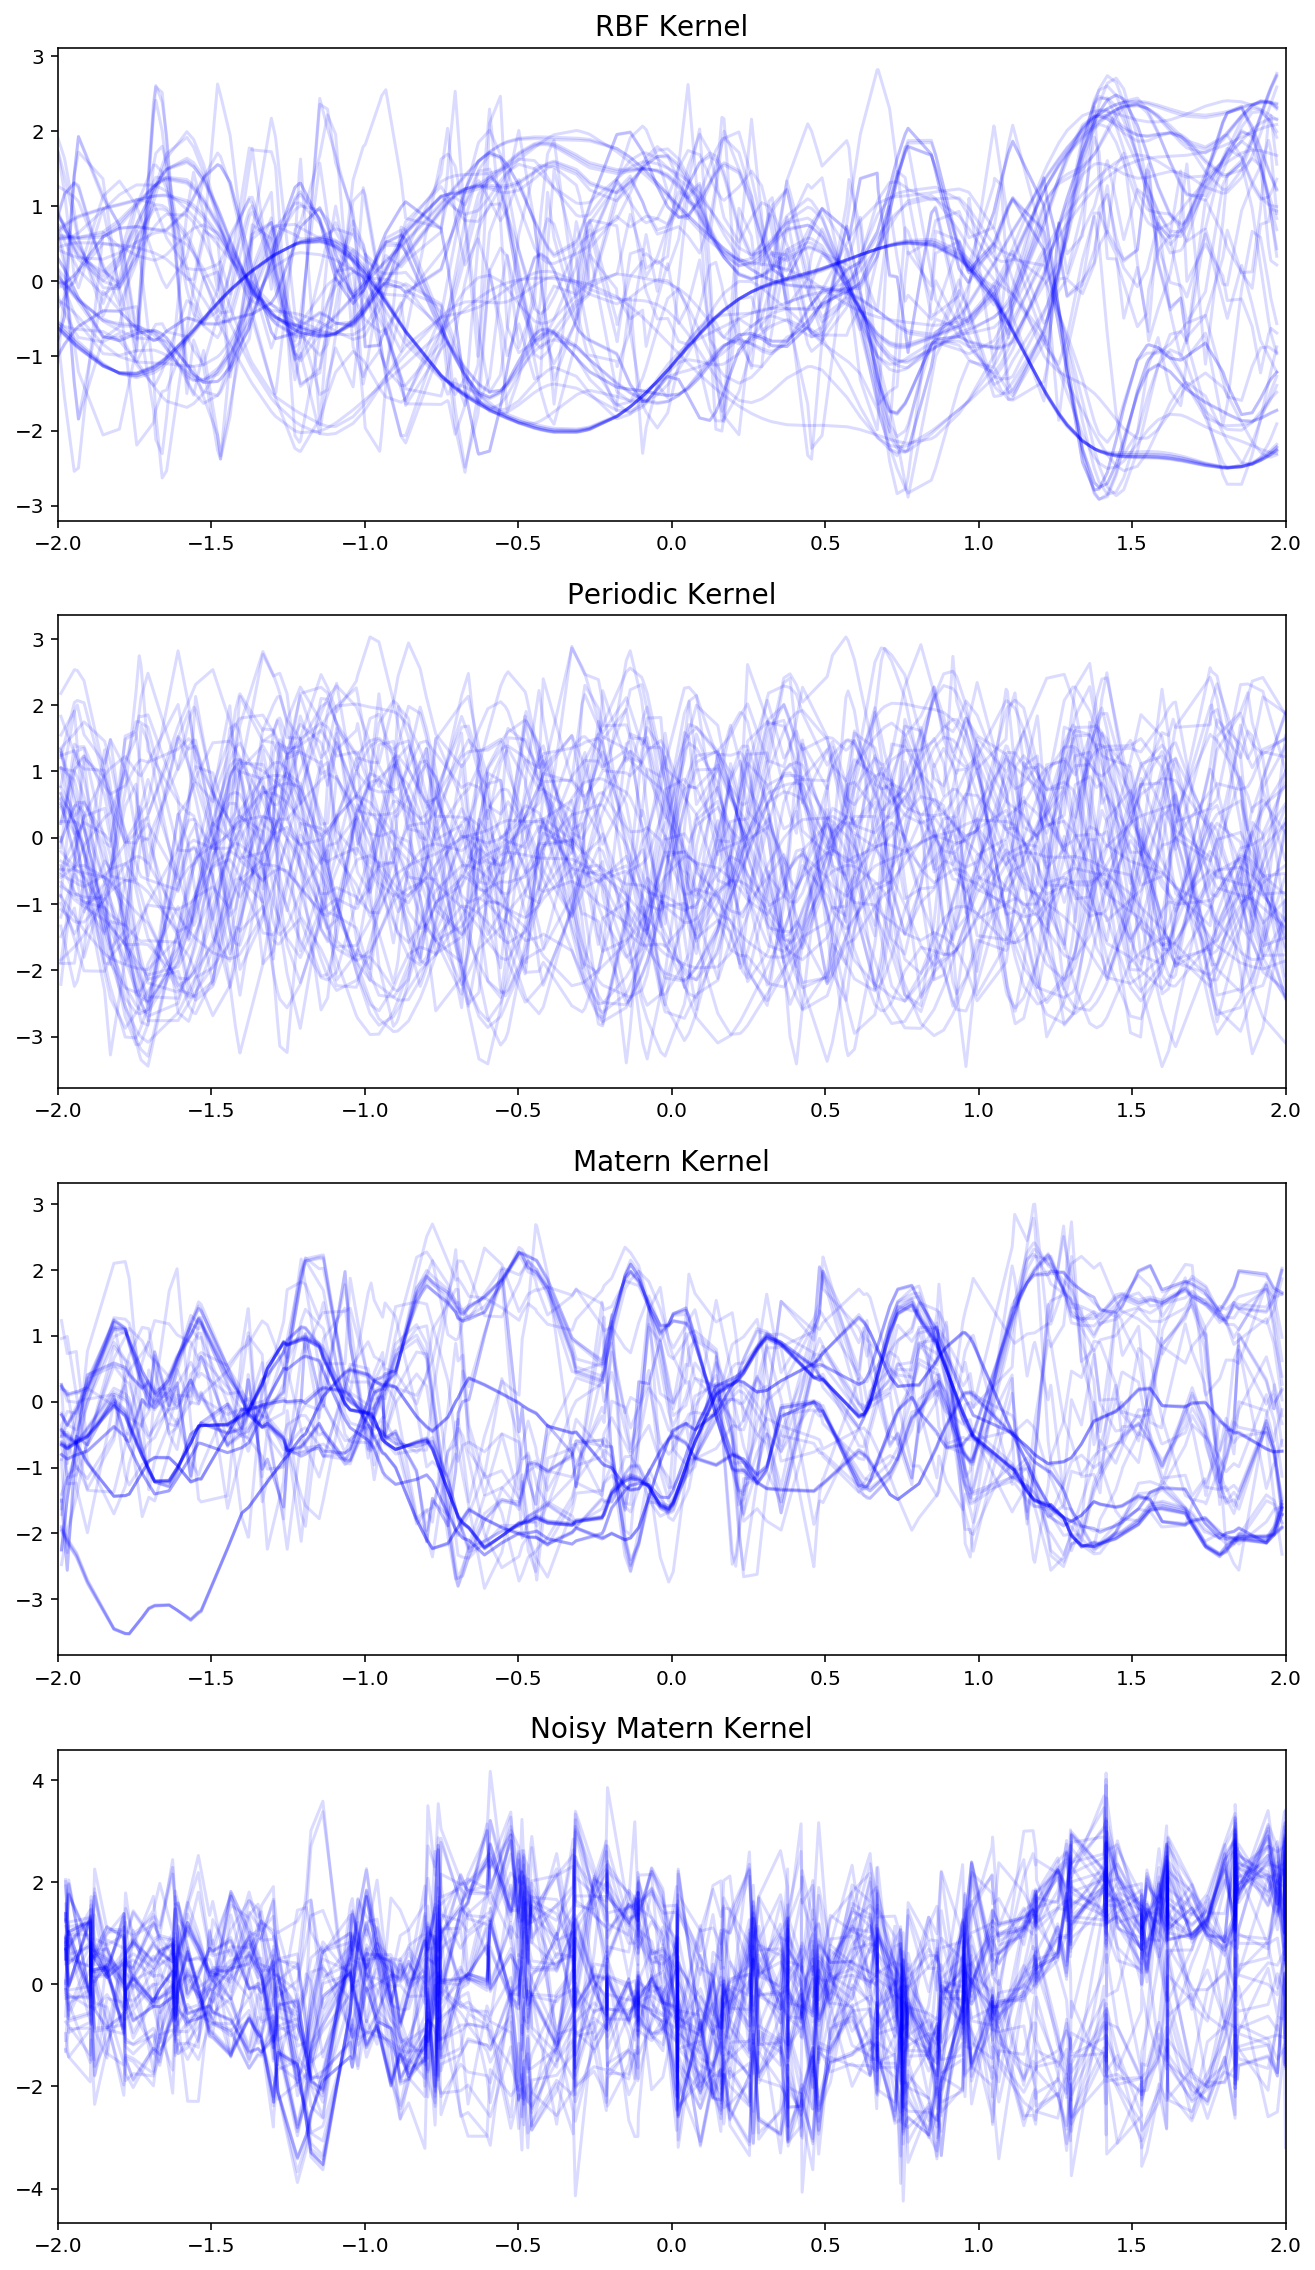

In [18]:
n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets))
for i, (k, dataset) in enumerate(datasets.items()):
    plot_dataset_samples(dataset, title="{}".format(k), ax=axes[i])

Let's define the context and target splitters. Here, we select uniformly between 0.01 and 0.5 context points and use all points as target. 

In [23]:
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5),
                                 targets_getter=get_all_indcs,
                                 is_add_cntxts_to_trgts=False) 

## Model

Neural Processes Family (NPFs) are a family of models, which use a neural network $Q_{\pmb\theta}$ to estimate the conditional predictive distribution

$$p(\mathrm{Y}_\mathcal{T} | \mathrm{X}_\mathcal{T}, \mathcal{C})$$

over a set of *target* values $\mathrm{Y}_\mathcal{T} := \{\mathbf{y}^{(t)}\}_{t=1}^T$
conditioned on a set of corresponding target features $\mathrm{X}_\mathcal{T} := \{\mathbf{x}^{(t)}\}_{t=1}^T$ and a *context* set of feature-value pairs $\mathcal{C} := \{(\mathbf{x}^{(c)}, \mathbf{y}^{(c)})\}_{c=1}^C$ . In this series of notebooks, I will use a unifying framework for NPFs. From a computation perspective, the family of models have three main components:

* The **encoder** $h_{\pmb{\theta}}$ takes as input a context point $(\mathbf{x}^{(c)}, \mathbf{y}^{(c)})$ and embeds it as $\mathbf{r}_c \in \mathbb{R}^d$. Typically, it is modelled as a multi-layer perceptron (MLP).

* The **aggregator** outputs a representation $\mathbf{r}_\mathcal{C}^{(t)} \in \mathbb{R}^d$, given all context embeddings $\{\mathbf{r}_c\}_{c=1}^C$ and a target features $\mathbf{x}^{(t)}$. As the input is an unordered set, the representor should be *permutation invariant* in $\mathcal{C}$. Standard NPs use a mean aggregation, which is independent of the target position
$$\mathbf{r}_\mathcal{C}^{(t)} = \frac{1}{C} \sum_{c=1}^C \mathbf{r}_c$$

* The **decoder** predicts a distribution over target values $\mathbf{y}^{(t)}$, conditioned on $\mathbf{r}_\mathcal{C}^{(t)}$. This is achieved through a neural network $g_{\pmb\theta}$, which outputs sufficient statistics $\pmb\phi^{(t)}$ of a Gaussian probability density function (PDF).

Formally:

$$
\begin{align}
p(\mathrm{Y}_\mathcal{T} | \mathrm{X}_\mathcal{T}, \mathcal{C}) 
&\approx Q_{\pmb\theta}(\mathrm{Y}_\mathcal{T} | \mathrm{X}_\mathcal{T}, \mathcal{C}) \label{eq::cnp_approx} \\
&= \prod_{t=1}^{T} Q_{\pmb\theta}(\mathbf{y}^{(t)} | \mathbf{x}^{(t)}, \mathcal{C})\label{eq::cnp_factor} \\
&= \prod_{t=1}^{T} Q_{\pmb\theta}(\mathbf{y}^{(t)} | \mathbf{r}_t, \mathbf{r}_\mathcal{C}^{(t)})\label{eq::cnp_rc} \\
&= \prod_{t=1}^{T} p(\mathbf{y}^{(t)} | \pmb\phi^{(t)})
\end{align}
$$

Where:

$$
\begin{align}
\mathbf{r}_c
&:= h_{\pmb\theta}(\mathbf{x}^{(c)}, \mathbf{y}^{(c)}) \label{eq::cnp_def_rc}
\\
\mathbf{r}_\mathcal{C}^{(t)}
&:= \mathrm{Agg}\left( \mathbf{r}_t, \{\mathbf{r}_c\}_{c=1}^{C} \right) \label{eq:cnp_def_agg}\\
\pmb\phi^{(t)} 
&:= g_{\pmb\theta}(  \mathbf{r}_t,\mathbf{r}_\mathcal{C}^{(t)}) \label{eq::cnp_def_phi} \\
\mathbf{r}_t
&:= h_{\pmb\theta}(\mathbf{x}^{(c)}) \label{eq::cnp_def_rt}
\end{align}
$$

The following figure shows the unifying NPF computational graph, as well as the specific aggregator module for Conditional NP | NP | Attentive NP. 

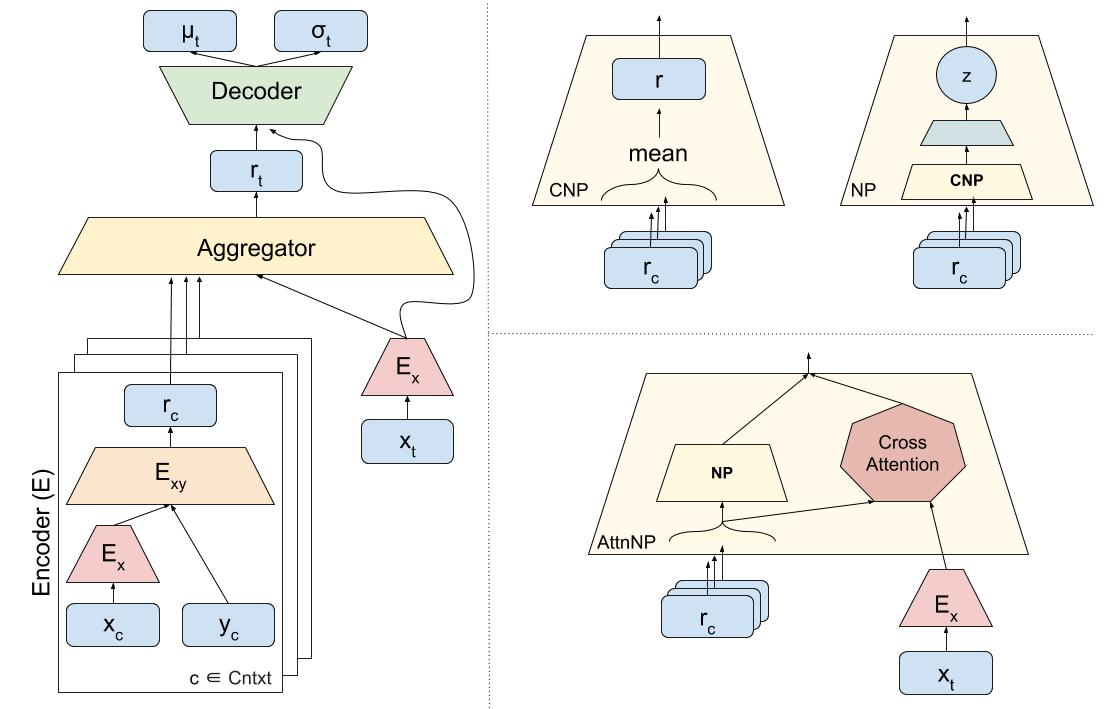

In [19]:
from IPython.display import Image
Image(filename='imgs/Neural Process Family.jpg')

The general model architecture is slightly different from the paper to make it modular and easy to extend. See the docstrings of `NeuralProcess` for more details.

Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension $d$ of hidden representations $r \in \mathbb{R}^d$.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
    - `Identity` : this is what they use in the paper but it doesn't work as well (less parameter sharing)
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `merge_flat_input(MLP, is_sum_merge=False)` : learn representation with MLP. `merge_flat_input` concatenates (or sums) X and Y inputs.
    - `merge_flat_input(SelfAttention, is_sum_merge=True)` : self attention mechanisms (as [Attentive Neural Process]). For more parameters (attention type, number of layers ...) refer to its docstrings.
    - `discard_ith_arg(MLP, 0)` if want the encoding to only depend on Y.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `merge_flat_input(MLP)` : predict with MLP.
    - `merge_flat_input(SelfAttention, is_sum_merge=True)` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process], but in [Image Transformer]). 
    - `discard_ith_arg(MLP, 0)` if want the decoding to only depend on $r$.
    

**Extensions**

- For Neural Process, see the [Tutorial 2 - Neural Process] notebook.
- For Attentive Neural Process, see the [Tutorial 3 - Attentive Neural Process] notebook.
- For Conditional Convolutional Process, see the [Tutorial 4 - Conditional Convolutional Process] notebook.
- For image datasets, see the [Tutorial 5 - Images] notebook.
- For super resolution images, see the [Tutorial 6 - Super Resolution Images] notebook.

[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb
[Tutorial 4 - Conditional COnvolutional Process]: Tutorial%204%20-%20Conditional%20Convolutional%20Process.ipynb
[Tutorial 5 - Images]: Tutorial%205%20-%20Images.ipynb
[Tutorial 6 - Super Resolution Images]: Tutorial%206%20-Super%20Resolution%20Images.ipynb

In [21]:
from neuralproc import NeuralProcessLoss, NeuralProcess, merge_flat_input
from neuralproc.predefined import MLP

let's define the model for every datasets

In [12]:
CNP_KWARGS = dict(XEncoder=get_uninitialized_mlp(n_hidden_layers=1), # share X encoding (not done in the paper) 
                 XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                            is_sum_merge=True),  # sum the encoded X and Y 
                 Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                          is_sum_merge=True),  # sum the encoded X and Y 
                 r_dim=128,  
                 PredictiveDistribution=Normal, # Gaussian predictive distribution
                 encoded_path="deterministic") # use CNP
CNP_KWARGS["get_cntxt_trgt"] = get_cntxt_trgt

TypeError: __init__() missing 2 required positional arguments: 'input_size' and 'output_size'

In [13]:
# initialize one model for each dataset
data_models = {name: (NeuralProcess(X_DIM, Y_DIM, **CNP_KWARGS), data) 
               for name, data in datasets.items()}

/master/neuralproc/utils/torchextend.py:53: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [14]:
from utils.helpers import count_parameters

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 98498


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

std: 2.528689786195755


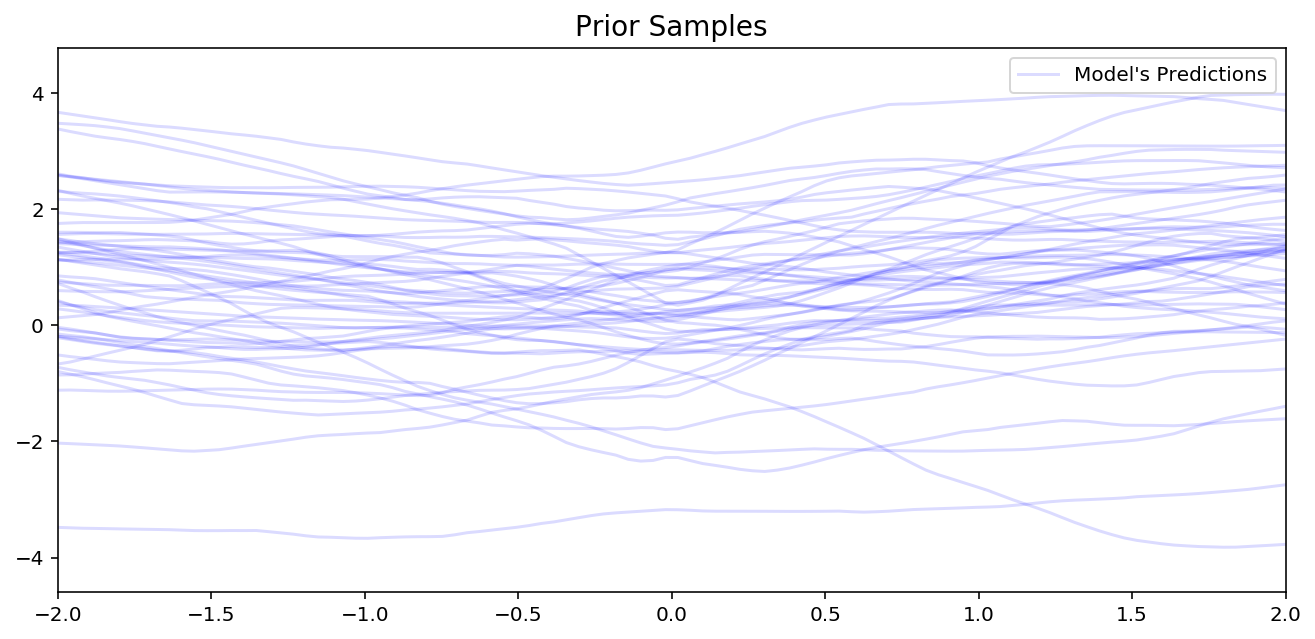

In [15]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, train_min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

Training is handled by [skorch](https://github.com/skorch-dev/skorch), which is a sklearn-style wrapper around pytorch. 

**Highltights**
- sklearn-style wrapper around pytorch. this is especially handy for downstream tasks to make a pipeline which does a task after being represented (i.e. transformed in sklearn jargon) by a CNP.
- many nice callbacks (including best model checkpoint used below)
- you can interrupt training and run again a cell: it will start where it last stoped


In [16]:
from torch.optim import Adam
from skorch.callbacks import ProgressBar, Checkpoint
from skorch import NeuralNet
from utils.helpers import get_only_first_item

def train_all_models_(data_models, chckpnt_dirname, is_retrain=False):
    """Train or loads IN PLACE a dictionary containing a model and a datasets"""
    for k,(neural_proc, dataset) in data_models.items():
        print()
        print("--- {} {} ---".format("Training" if is_retrain else "Loading", k))
        print()

        chckpt = Checkpoint(dirname=chckpnt_dirname.format(k), 
                            monitor='train_loss_best') # train would be same as validation as always resamples

        model = NeuralNet(neural_proc, NeuralProcessLoss,
                          iterator_train__shuffle=True, # shuffle iterator
                          train_split=None,  # don't use cross validation dev set
                          warm_start=True, # continue training if stop and restart
                          device="cuda" if torch.cuda.is_available() else "cpu",
                          optimizer=Adam,
                          max_epochs=50, 
                          batch_size=64,
                          lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                          callbacks=[ProgressBar(), chckpt]) 

        if is_retrain:
            # give both X and y to `forward`
            _=model.fit({'X': get_only_first_item(dataset), "y": dataset.targets})

        # load in all case => even when training loads the best checkpoint
        model.initialize()
        model.load_params(checkpoint=chckpt)

In [17]:
train_all_models_(data_models, "results/notebooks/neural_process/cnp", is_retrain=False) # if false load precomputed


--- Loading rbf ---


--- Loading periodic ---


--- Loading matern ---


--- Loading noisy-matern ---



# Inference

## Trained Prior

The prior should now encode some information about the shapes of the functions. Neural processes can be thought of methods that learn a kernel function from the data, if they are effective the trained prior should thus be very similar to the the samples the datasets previously seen.

In [18]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.7762215000391006
std: 1.6632111346721643
std: 1.482384616732598
std: 1.773127093911171


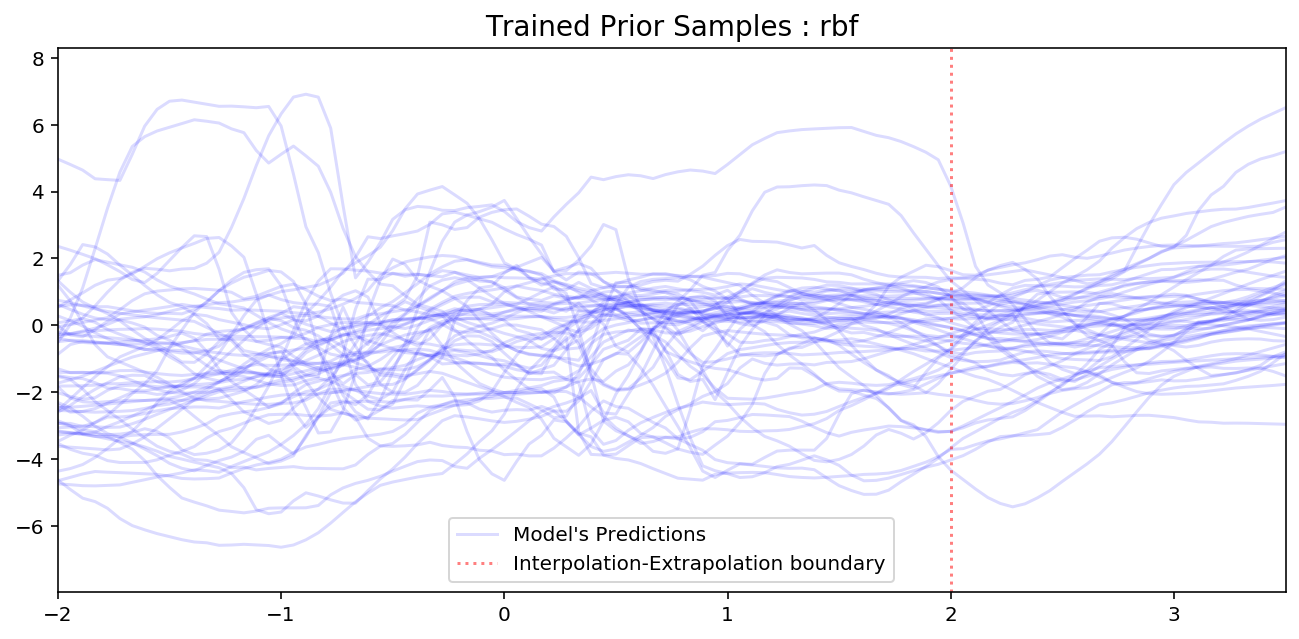

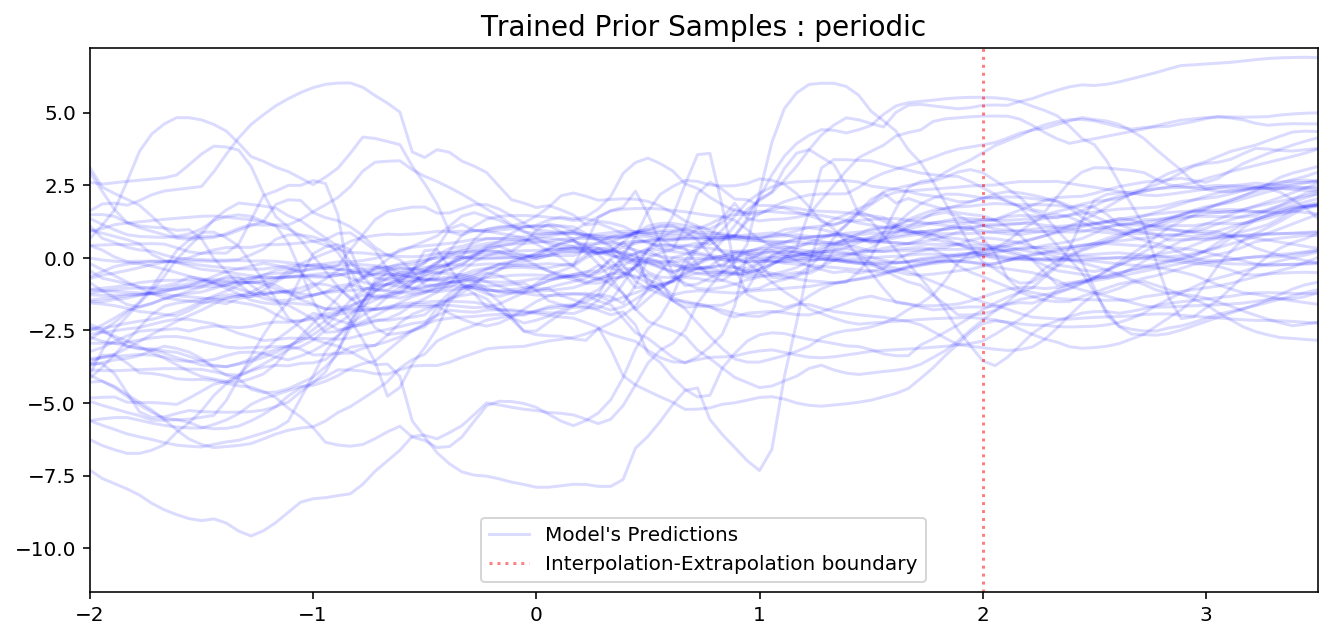

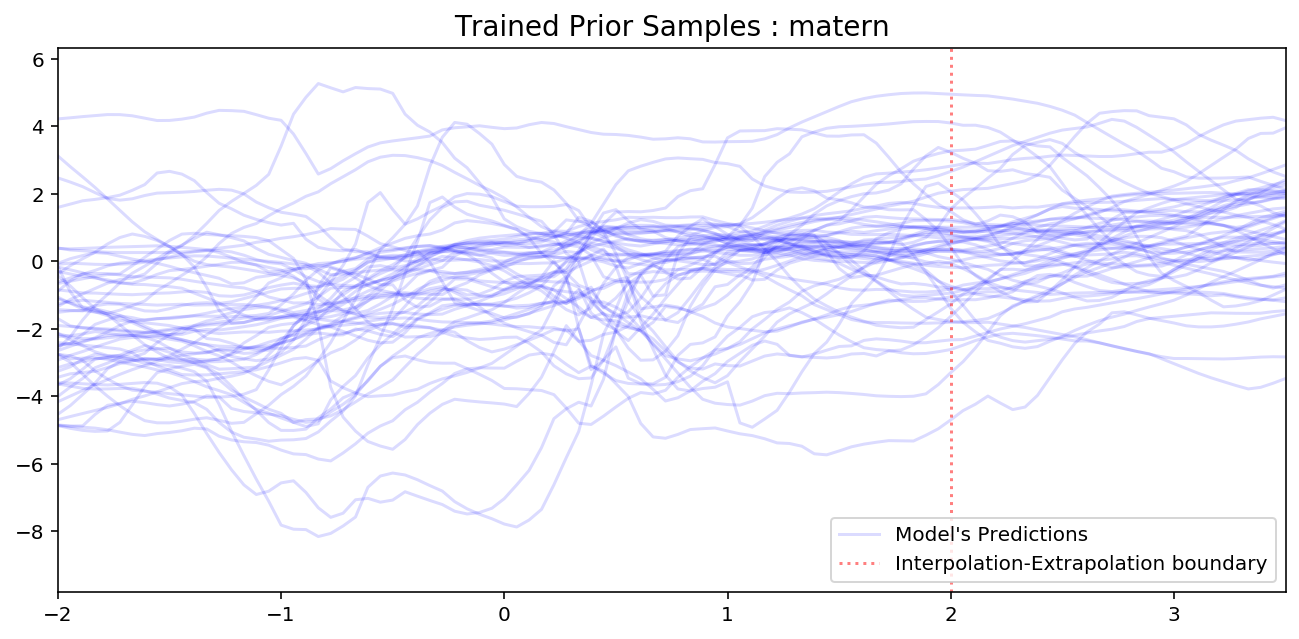

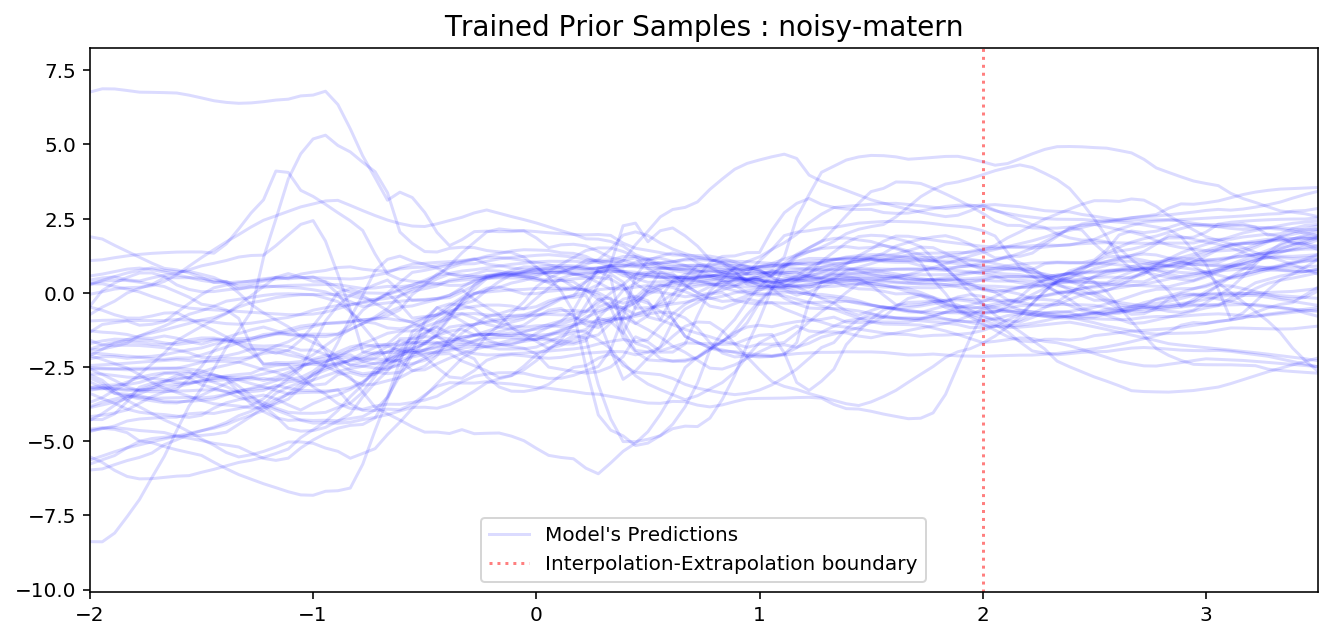

In [19]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

We see that the trained priors are not too bad but cannot learn very smooth samples (e.g. for all besides Matern).

## Posterior

Let us now investigate the posterior over functions when conditioned on some new context points.

std: 1.0470126867294312
std: 0.8570702075958252
std: 0.7134988903999329
std: 0.8848128318786621


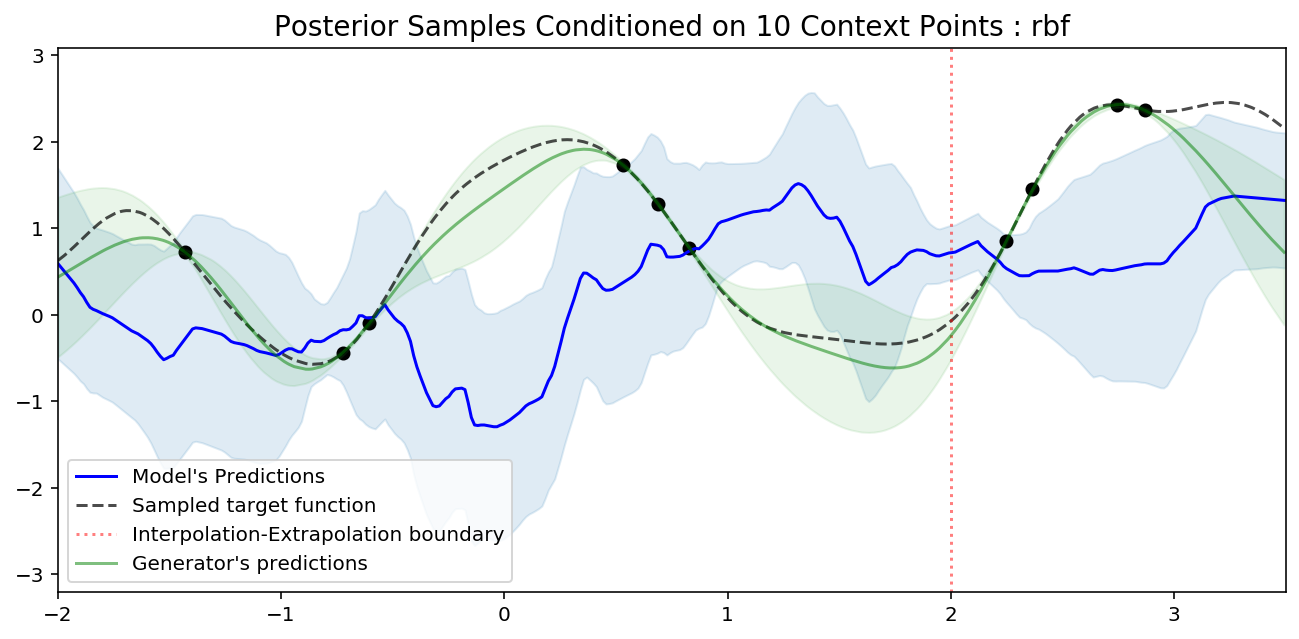

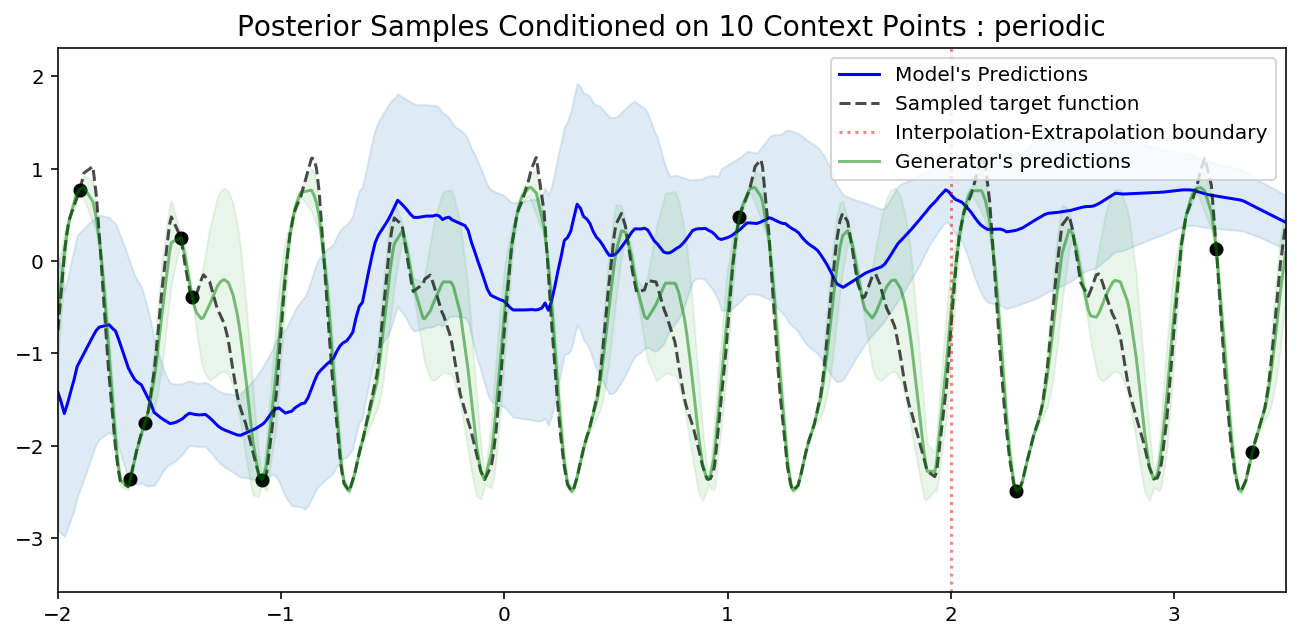

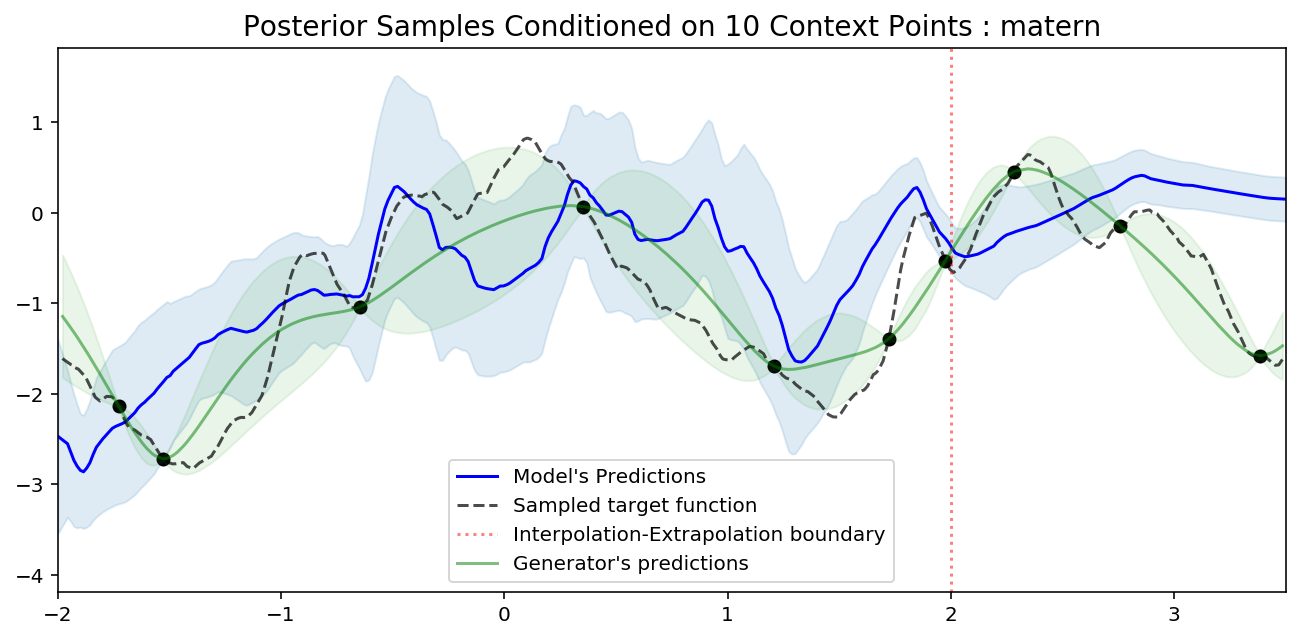

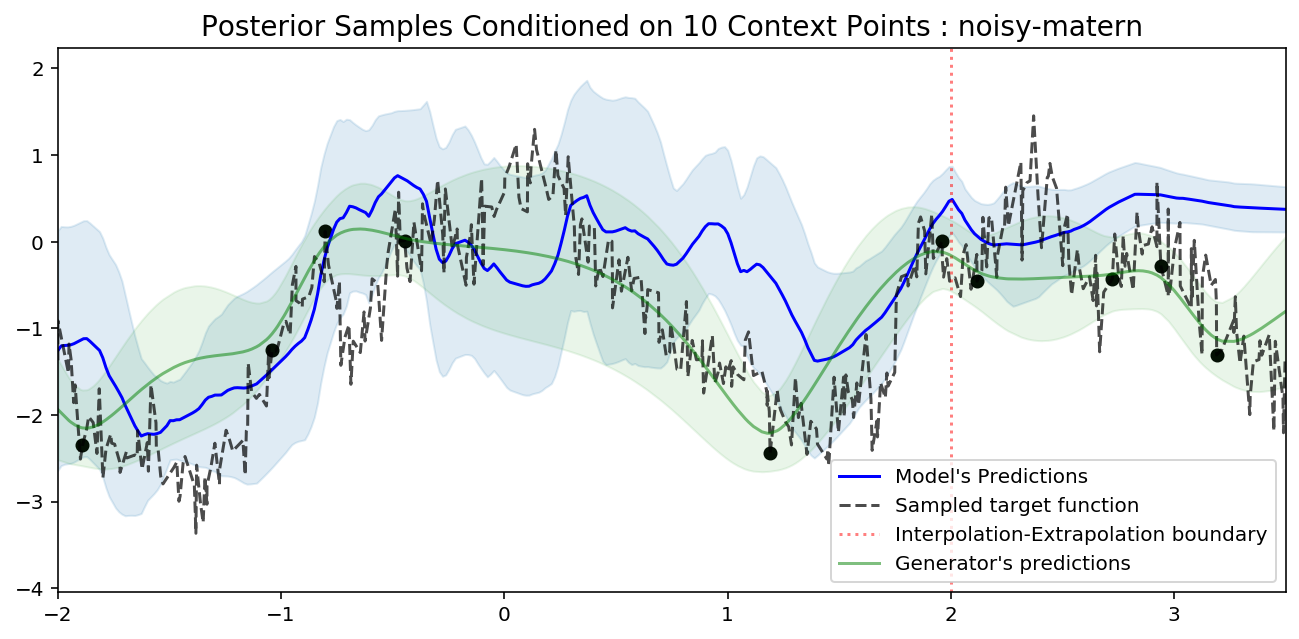

In [20]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

To have a better understanding of uncertainty let's look at only 2 context points:

std: 1.5807651281356812
std: 1.339920163154602
std: 1.1808472871780396
std: 1.0450831651687622


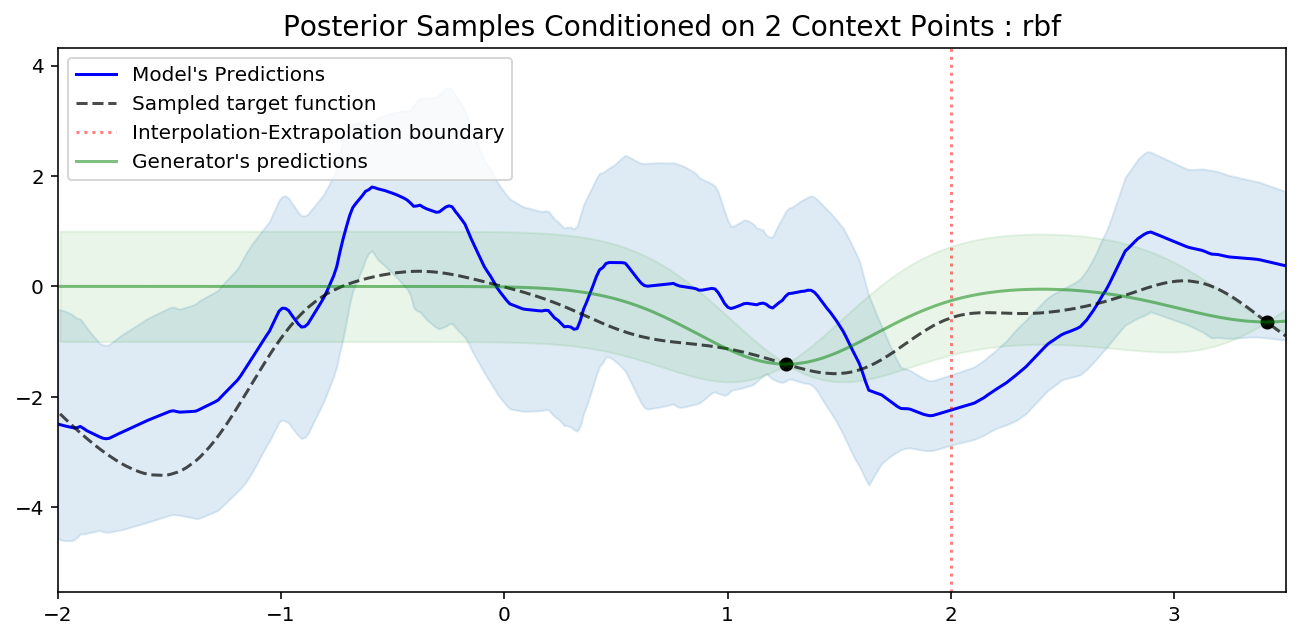

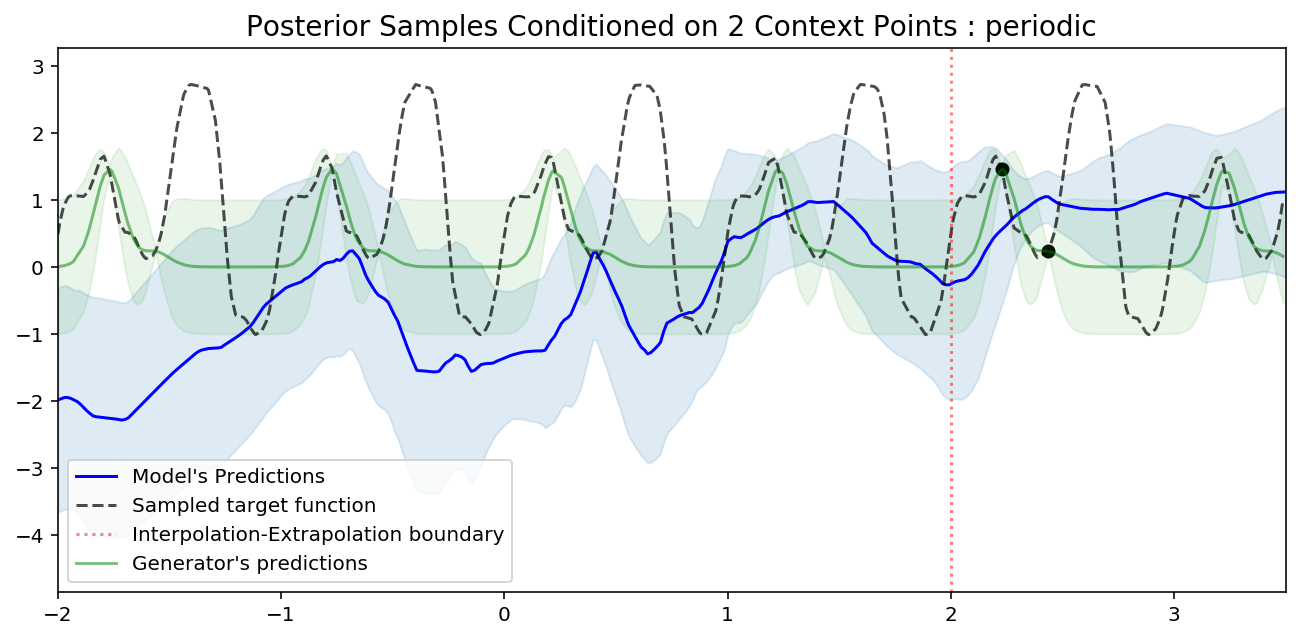

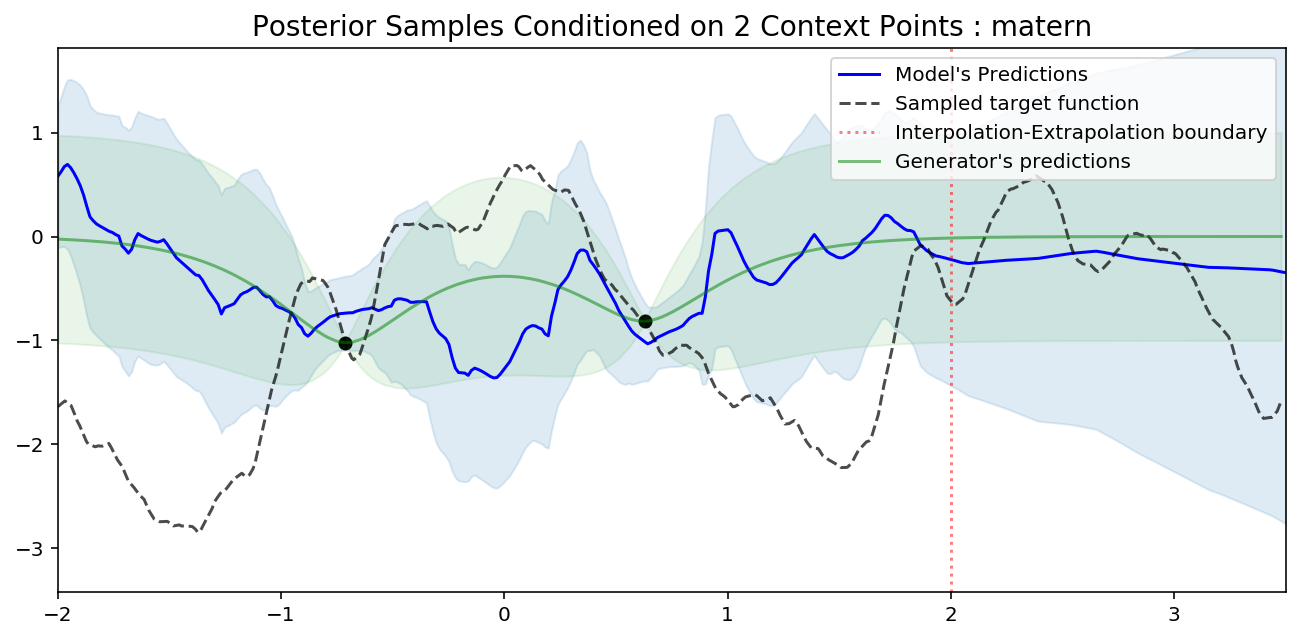

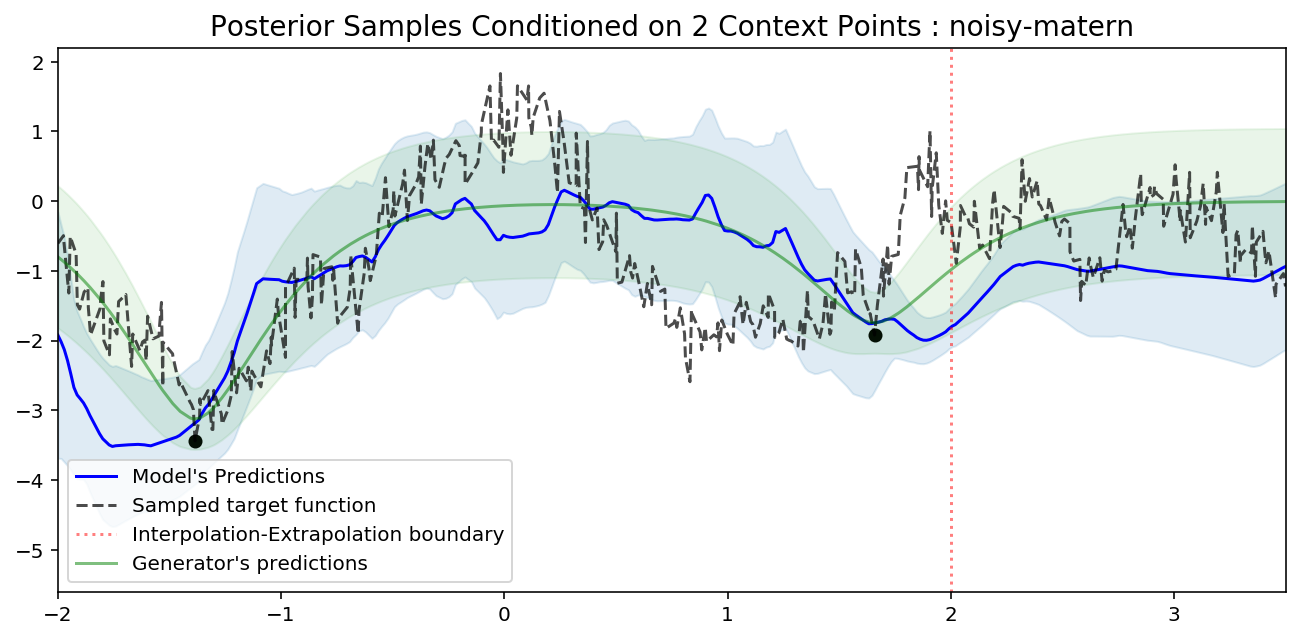

In [21]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

What about 20:

std: 0.7427908778190613
std: 0.7521397471427917
std: 0.6175443530082703
std: 0.7628170847892761


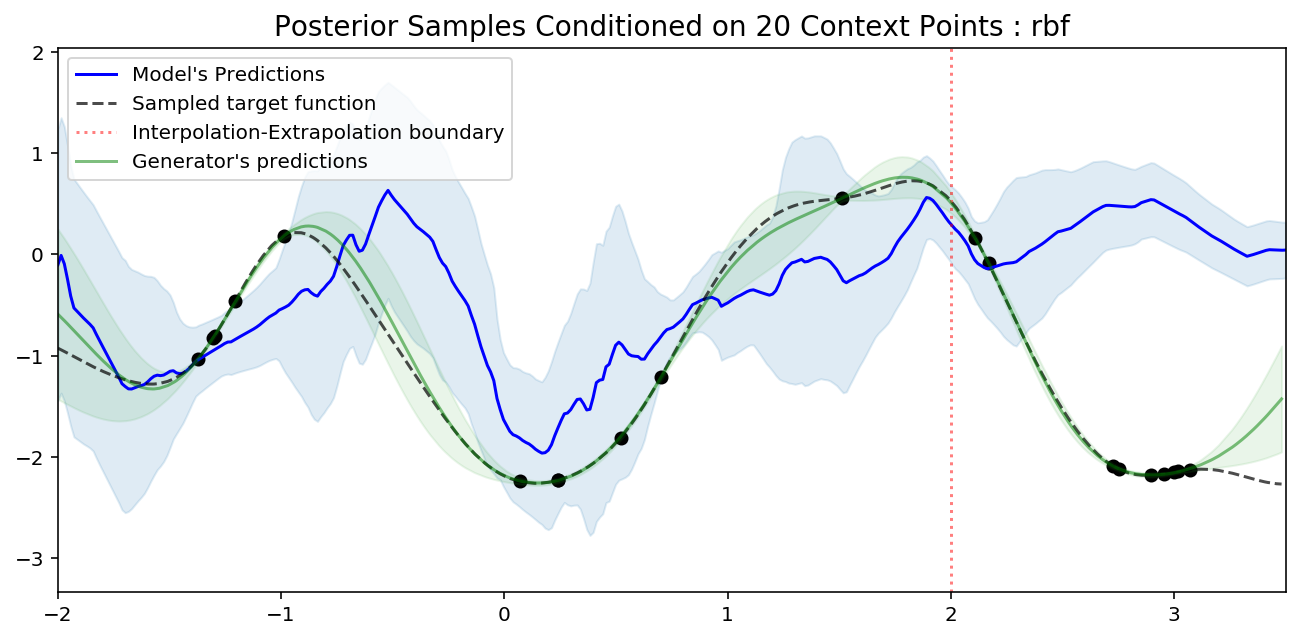

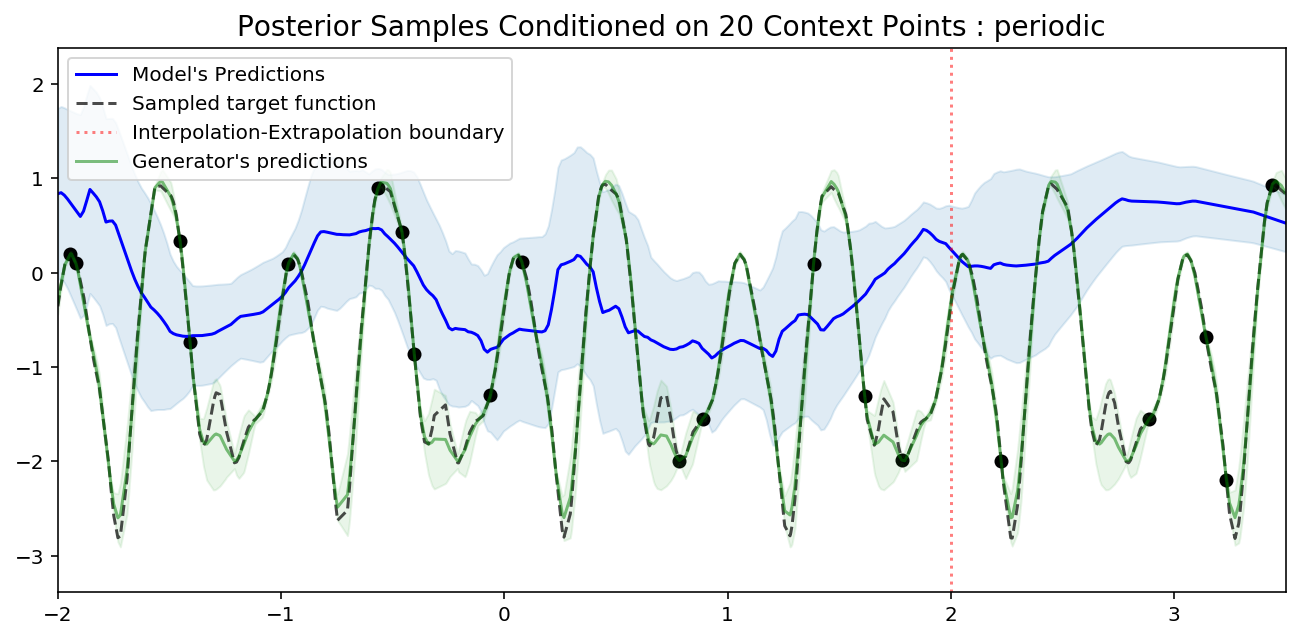

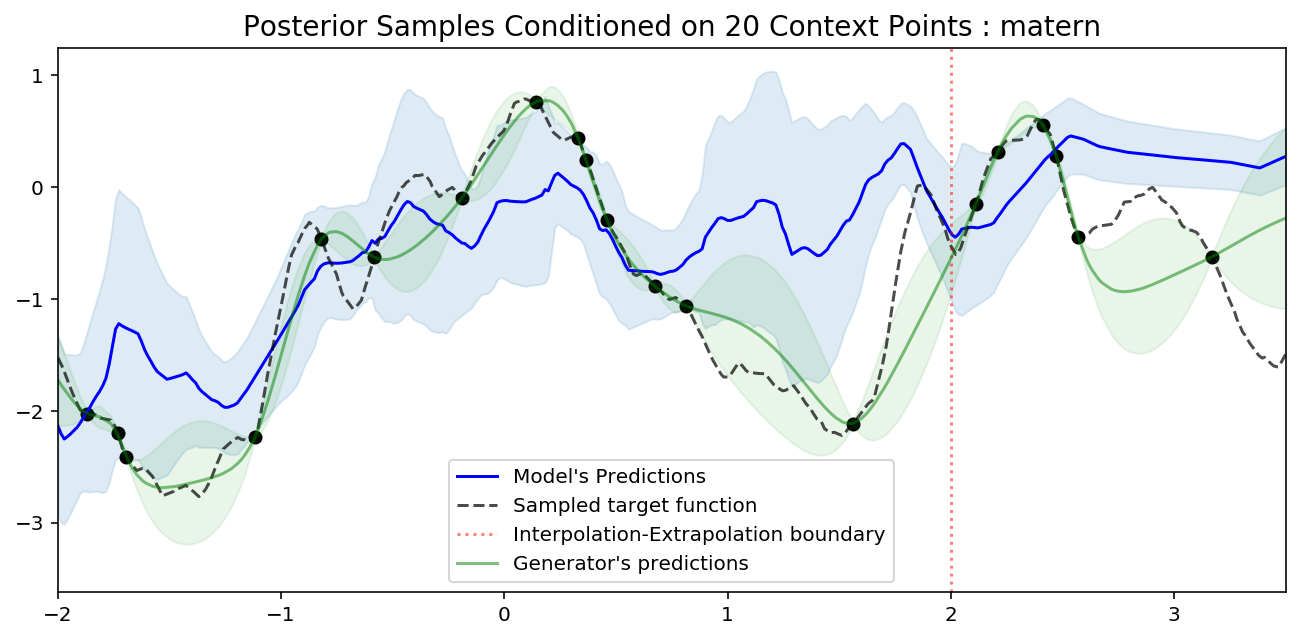

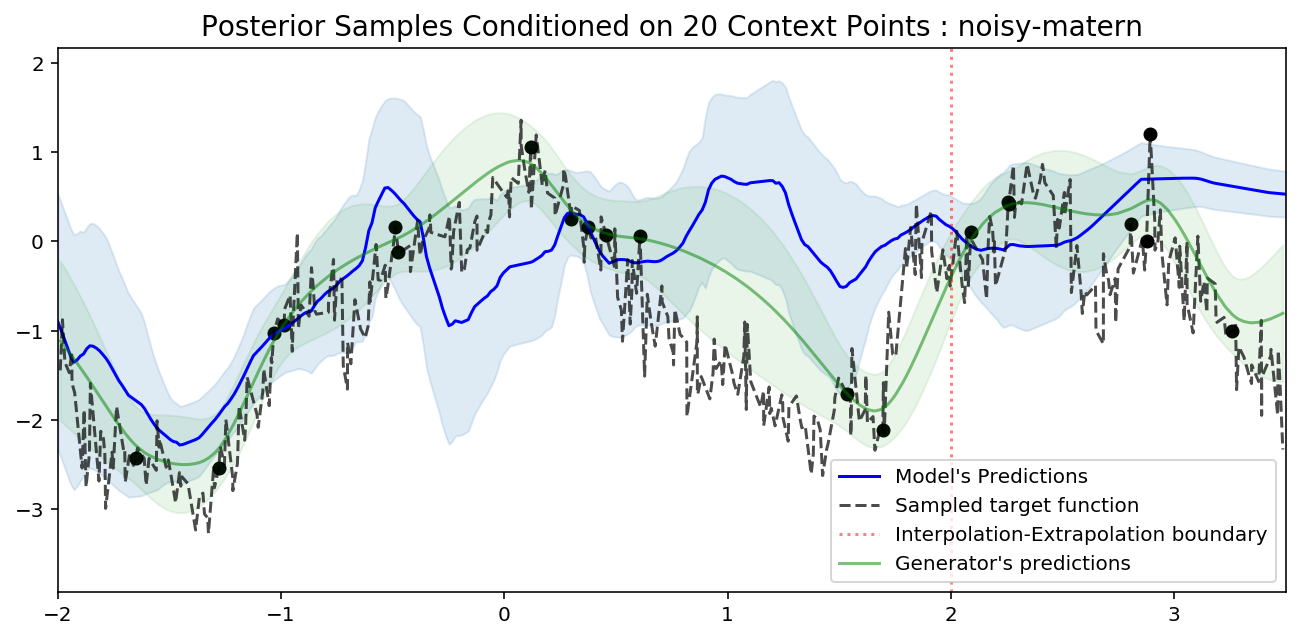

In [22]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the model learned something but the predictions are pretty bad (not that would improve slightly when runnign for longer but never great predictions).

**Good**:
- The standard devation does not collapse to the minimum value it can output (i.e. 0.1). 
- It is also relatively uncertain far from context points. ¨

**Bad**:
- it underfits and the mean does not often pass through the context points (and the variance doesn't decrease at those points).
- periodicity pattern is not periodic
- miserably fales when extrapolating even when there are context points there.

Note: the results were better when using the whole target set during training: probably showing that given more signal it can work (although we already use a lot of signal here!). I did not keep the other models to have a fair comparaison with other models and to do like in the paper.

- `get_cntxt_trgt` :  Function that split the input into context and target points. The splitting is done is done in the forward call to make easy to use with standard deep learning frameworks and datasets. Possible values:
    - `CntxtTrgtGetter()` does the target and context splitting for you based on indices. How to select the indices can easily be modified by parameters (by default random subset for context and all targets). When using this class you can also directly pass predefined context and target indices to the `forward` call. More details in the docstrings.
    - `GridCntxtTrgtGetter()` split grids of values (e.g. images) into context and target points. How to select the indices can easily be modified by parameters (random subsets, half grids, ...). When using this class you can also directly pass predefined context and target masks to the `forward` call. More details in the docstrings.
    - your own callable function, such that `X_cntxt, Y_cntxt, X_trgt, Y_trgt = get_cntxt_trgt(X, y, **kwargs)`, for example if you already have the context and target point, put them in a dictionary and split the dictionary in `get_cntxt_trgt`.
    
    
**Additional Parameters : (Attentive) Neural Process**

- `encoded_path` : Which path(s) to use:
    - `"deterministic"` uses a [Conditional Neural Process] (no latents), where the decoder gets a deterministic representation as input (function of the context). 
    - `"latent"` uses a [Neural Process], where the decoder gets a sample latent representation as input (function of the target during training and context during test).
    - If `"both"` concatenates both representations as described in [Attentive Neural Process].
- `LatentEncoder` : Encoder which maps $r \to [\mu_z; f(\sigma_z)]$. Only used if `encoded_path` in `["latent", "both"]`.

To use cross-attention instead of aggregation (i.e. [Attentive Neural Process]) replace `NeuralProcess` with `AttentiveNeuralProcess`. Many different attention mechanisms are available (image transformer, multihead, dot head, manhattan ...), see its docstrings for more details. 